In [2]:
#!pip install pytorch-lightning

In [12]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('data/unhealthy_comment_corpus/train.csv')
test_data = pd.read_csv('data/unhealthy_comment_corpus/test.csv')

train_data.head()

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


<Axes: >

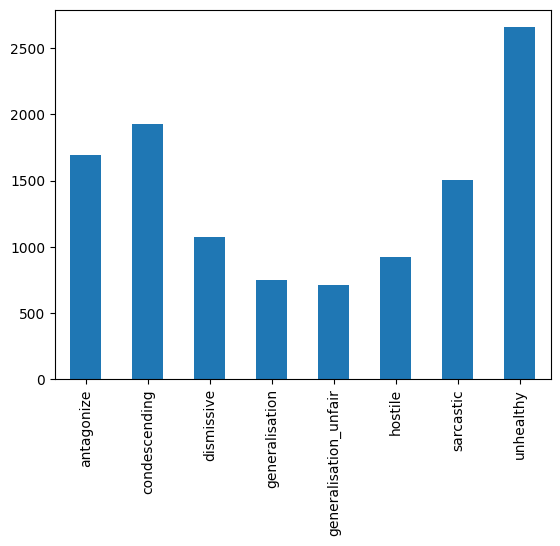

In [13]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)
attributes = ['antagonize', 'condescending', 'dismissive', 'generalisation', 'generalisation_unfair', 'hostile', 'sarcastic', 'unhealthy']

train_data[attributes].sum().plot(kind='bar')

In [32]:
from torch.utils.data import Dataset
import torch

class UCC_Dataset(Dataset):
    def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 128, sample = 5000):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.sample = sample
        self.prepare_data()
        
    def prepare_data(self):
        data = pd.read_csv(self.data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)
        if self.sample is not None:
            unhealthy = data.loc[data[self.attributes].sum(axis=1) > 0]
            healthy = data.loc[data[self.attributes].sum(axis=1) == 0]
            self.data = pd.concat([unhealthy, healthy.sample(n=self.sample, random_state=42)], ignore_index=True)
        else:
            self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        comment = str(item.comment)
        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus(comment, 
                                            add_special_tokens=True, 
                                            return_tensors='pt',
                                            truncation=True,
                                            max_length=self.max_token_len,
                                            padding='max_length',
                                            return_attention_mask=True)
        return {
            'input_ids': tokens.input_ids.flatten(),
            'attention_mask': tokens.attention_mask.flatten(),
            'labels': attributes
        }

In [33]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(data_path='data/unhealthy_comment_corpus/train.csv', 
                     tokenizer=tokenizer, 
                     attributes=attributes)

ucc_ds_val = UCC_Dataset(data_path='data/unhealthy_comment_corpus/test.csv', 
                         tokenizer=tokenizer, 
                         attributes=attributes, 
                         sample=None)

In [34]:
ucc_ds.__getitem__(0)

/var/folders/dg/gv_5rj1j60z6gsgwh0rqwgf80000gn/T/ipykernel_40090/1011466821.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attributes = torch.FloatTensor(item[self.attributes])


{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [35]:
len(ucc_ds)

9960

DATA MODULE

In [36]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [37]:
class UCC_Data_Module(pl.LightningDataModule):
    def __init__(self, train_path, val_path, attributes, batch_size: int = 16, max_token_len: int = 128, model_name: str = 'roberta-base'):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
    def setup(self, stage = None):
        if stage in (None, 'fit'):
            self.train_dataset = UCC_Dataset(data_path=self.train_path, 
                                             tokenizer=self.tokenizer, 
                                             attributes=self.attributes)
            self.val_dataset = UCC_Dataset(data_path=self.val_path, 
                                            tokenizer=self.tokenizer, 
                                            attributes=self.attributes,
                                            sample=None)
        if stage == 'predict':
            self.val_dataset = UCC_Dataset(data_path=self.val_path, 
                                            tokenizer=self.tokenizer, 
                                            attributes=self.attributes,
                                            sample=None)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
    
    def predict_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)

In [38]:
ucc_data_module = UCC_Data_Module(train_path='data/unhealthy_comment_corpus/train.csv', 
                                  val_path='data/unhealthy_comment_corpus/test.csv', 
                                  attributes=attributes)

In [39]:
ucc_data_module.setup()

In [40]:
dl = ucc_data_module.train_dataloader()

In [41]:
len(dl)

623

MODEL

In [43]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [56]:
class UCC_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(self.config['model_name'], return_dict=True)
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        torch.nn.init.xavier_uniform_(self.hidden.weight)
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
        self.dropout = nn.Dropout()
        
    def forward(self, input_ids, attention_mask, labels=None):
        # roberta model
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, dim=1)
        # neural network classification layers
        pooled_output = self.hidden(pooled_output)
        pooled_output = self.dropout(pooled_output)
        pooled_output = F.relu(pooled_output)
        logits = self.classifier(pooled_output)
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return {'loss': loss, 
                'predictions': logits,
                'labels': batch['labels']}
        
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        self.log('validation_loss', loss, prog_bar=True, logger=True)
        return {'validation_loss': loss, 
                'predictions': logits,
                'labels': batch['labels']}
        
    def predict_step(self, batch, batch_index):
        _, logits = self(**batch)
        return logits
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.config['learning_rate'], weight_decay=self.config['weight_decay'])
        total_steps = self.config['train_size'] / self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=warmup_steps, 
                                                    num_training_steps=total_steps)
        return [optimizer], [scheduler]


In [57]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'learning_rate': 1.5e-6,
    'weight_decay': 0.001,
    'warmup': 0.2,
    'train_size': len(ucc_data_module.train_dataloader()),
    'batch_size': 128,
    'n_epochs': 100
}

model = UCC_Classifier(config=config)

TRAIN

In [60]:
# datamodule
ucc_data_module = UCC_Data_Module(train_path='data/unhealthy_comment_corpus/train.csv', 
                                  val_path='data/unhealthy_comment_corpus/test.csv', 
                                  batch_size=config['batch_size'], 
                                  attributes=attributes)
ucc_data_module.setup()

# model
model = UCC_Classifier(config=config)

# train
trainer = pl.Trainer(max_epochs=config['n_epochs'],
                     num_sanity_val_steps=50,
                     logger=True,
                     log_every_n_steps=10)

trainer.fit(model, ucc_data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/user/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M | eval 
1 | hidden           | Linear            | 590 K  | train
2 | classifier       | Linear            | 6.2 K  | train
3 | loss_func        | BCEWithLogitsLoss | 0      | train
4 | dropout          | Dropout           | 0      | train
---------------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
33

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/user/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reducti

NameError: name 'exit' is not defined